# Práctico 1: Clustering - Text Mining 2021

Notebook sobre el práctico 1 de la materia Mineria de Texto para Datos, materia correspondiente de la carrera Lic. En Ciencias de la Computación de FaMAF, UNC.

Estudiante: Garagiola Nazareno


Clustering es el proceso de agrupar un conjunto de elementos (en este caso de palabras) que tengan similitudes.
Hipotesis de Clustering: Palabras en el mismo cluster, tienen un comportamiento similar con respecto a la informacion que contienen.

---
## Requerimientos

Instalamos las librerias necesarias para el procesamiento.

In [1]:
!python3 -m spacy download es_core_news_md > trash.txt

In [148]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

---
## Carga del Corpus

Leemos el corpus a estudiar, hacemos algunos reemplazos para correjir un poco el texto.

Tomamos los primeros 0.5 M - 2 caracteres (ese numero ya que coincide con el fin de un parrafo).

In [220]:
f = open("lavoztextodump.txt", 'r')
text = f.read()[:500000-2] 
text = text.replace('"', '')
text = text.replace('-\n', '\n')
text = text.replace('&#','')

Cargamos el texto usando [Spacy](https://spacy.io/), tomamos los lemmas del texto y las palabras que aparezcan. Luego, hago un conteo de la cantidad de lemmas que aparecieron en el documento.

In [221]:
nlp = spacy.load("es_core_news_md", vectores=False, entity=False)

lemmas = []
words = []
doc = nlp(text)
for token in doc:
    if len(token) > 1 and token.is_alpha: # and not token.is_ascii and not token.is_digit:
        lemmas.append(token.lemma_.lower())
        words.append(token.text)

counter_lemma = Counter(lemmas)

Si están trabajando en Colab, es normal que al hacer el load de Spacy aparezca un error.

**`ModuleNotFoundError: No module named 'es_core_news_md'`**.

Reinicien el Kernel/Runtime (usen el menú de arriba Runtime->restart runtime) y salteen la celda de instalación (la primera que dice lo de abajo).

    !python3 -m spacy download es_core_news_md > trash.txt


---
## Preprocesamiento

Definimos algunas funciones que nos van a servir para poder filtrar palabras y poder seleccionar que palabras del documento vamos a analizar. Luego cargamos diccionarios con las caracteristicas de cada palabra que serviran para poder vectorizar estos lemmas.
En la variable MIN_FREQ especificamos la cantidad minima de veces que queremos que aparezca cada lemma a estudiar. 

In [222]:
MIN_FREQ = 30

def word_filter(token):
    """
    Pequeña funcion que usaremos para filtrar las palabras
    """
    return (not token.is_alpha) or (token.is_digit) or counter_lemma[token.lemma_] < MIN_FREQ

with open("stopwords.txt",'r') as s:
    stopwords = s.read().split('\n')

def not_a_stopword(token):
    """
    Funcion que toma un token de Spacy y revisa que su lemma sea o on una 
    stopword en español
    """
    return (token.is_alpha and (not token.lemma_.lower() in stopwords))


def immediate_related_words(span):
    """
    Funcion que a partir de un Span (parte continua del doc) retorna una lista
    con los lemmas de las palabras que no sean stopwords
    """
    tokens = list(filter(not_a_stopword, doc[close_lft:close_rgt]))
    return list(map(lambda token: token.lemma_, tokens))

def keywords_in(span):
    """
    Funcion que a partir de un Span, retorna una lista con los lemmas de las 
    palabras del span que no sean stopwords ni tampoco no sean relevantes.
    (la funcion )
    """
    tokens = list(filter(
        lambda token: not word_filter(token) and not_a_stopword(token), span))
    return list(map(lambda token: token.lemma_, tokens))


In [223]:
count = 0
for word in counter_lemma:
    count += 1 if counter_lemma[word] >= MIN_FREQ else 0
print(f"Cantidad de lemmas a estudiar: {count}")

Cantidad de lemmas a estudiar: 298


Creo diccionarios para cada una de las caracteristicas y los inicializo para cada lemma que pasan el filtro.

* Part of Speech
* Dependencias
* Contexto cercano sin stopwords
* Contexto mayor, con palabras claves
* Triplas de dependencias

In [224]:
triplas = {}
tag = {}
pos = {}
close_context = {}
large_context = {}

for token in doc:
    if word_filter(token): continue
    triplas[token.lemma_] = {}
    tag[token.lemma_] = {}
    pos[token.lemma_] = {}
    close_context[token.lemma_] = {}
    large_context[token.lemma_] = {}

Cargo cada diccionario para cada palabra que pasa el filtro, con las caracteristicas que seleccionamos.

Definimos dos variables para el tamaño de ventana de los dos contextos que tomamos, el inmediato y el mayor.



In [ ]:
close_window, large_window = 3, 20
for token in doc:
    if word_filter(token): continue

    i = token.i
    word = token.lemma_.lower()
    # Cargo part of speech de cada palabra lematizada
    if not token.pos_ in pos[word].keys():
        pos[word][token.pos_] = 0
    pos[word][token.pos_] += 1

    # Cargo tag de cada palabra lematizada
    if not token.tag_ in tag[word].keys():
        tag[word][token.tag_] = 0
    tag[word][token.tag_] += 1

    #Triplas de dependencias. Notar que busco el root de la frase en la que la 
    #palabra siguiente este, y esta puede no necesariamente estar en mis palabras
    #claves que superan el filtro.
    if not i == len(doc) - 1:
        tripla = (f"obj: {word} - dep : {token.dep_} - root: {doc[i+1].head.lemma_}") # - context: {span}")
        if not tripla in triplas[word].keys():
            triplas[word][tripla] = 0
        triplas[word][tripla] += 1

    #contexto inmediato, con una ventana 1 de distancia, sin stopwords
    close_lft, close_rgt = i-close_window, i+close_window
    if not (close_lft <= 0 and close_rgt >= len(doc)):
        imm_related_words = immediate_related_words(doc[close_lft:close_rgt])
        for w in imm_related_words:
            if w == word: continue
            if not w in close_context[word].keys():
                close_context[word][w] = 0
            close_context[word][w] += 1

    #contexto mas grande, solo de las palabras que me interesan sin stopwords
    #y que van a estar en un cluster luego.
    large_lft, large_rgt = i-large_window, i+large_window
    if not (large_lft <= 0 and large_rgt >= len(doc)):
        keywords_in_context = keywords_in(doc[large_lft: large_rgt])
        for w in keywords_in_context:
            if w == word: continue
            if not w in large_context[word].keys():
                large_context[word][w] = 0
            large_context[word][w] += 1

"""
for sent in doc.sents:
    for token in sent:
        if word_filter(token): continue
        i = token.i
        word = token.lemma_.lower()
        keywords_in_context = keywords_in(sent)
        for w in keywords_in_context:
            if w != word and not w in large_context[word].keys():
                large_context[word][w] = 0
            large_context[word][w] += 1
"""
pass
#arriba, otra forma para tomar el large_context

Cargamos todas las caracteristicas que recogimos y las agrupamos en un nuevo diccionario cuyas claves tambien son las palabras lematizadas que analizamos.

In [226]:
feats = {}
for token in doc:
    if word_filter(token): continue
    word = token.lemma_
    feats[word] = {**tag[word], **pos[word], **triplas[word], **large_context[word], **close_context[word]}

In [ ]:
print(f"Sample word 'que': {feats['que']}")

---
## Vectorización

Luego del pre-procesamiento, tenemos un diccionario de la forma {"palabra":"caracteristicas"}. A este le removemos las claves e ingresamos las caracteristicas (que son un diccionario) a un arreglo, el cual [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) lo transformara en una matriz, con filas que representan las palabras y en cada columna un valor para cada caracteristica.

In [228]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=False)
features, key_words, wid = [], {}, 0
for word in feats:
    key_words[word] = wid
    wid += 1
    features.append(feats[word])
matrix = vectorizer.fit_transform(X=features)


Ahora debemos normalizar la matriz (es decir, que los vectores tengan valores en el intervalo [0,1] y con norma 1).

Usamos [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html), otra herramienta de sklearn para poder reducir la dimensionalidad de la matrix y descartar aquellos valores que tengan poca varianza, es decir caracteristicas que no varien mucho entre las palabras.

El valor VARIANCE_THRESHOLD es definido por el usuario

In [229]:
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold

VARIANCE_THRESHOLD = 1e-7

selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)

normed_matrix = normalize(matrix, axis=1, norm='l1')

reduced_matrix = selector.fit_transform(normed_matrix)

print(matrix.shape, normed_matrix.shape, reduced_matrix.shape)

(273, 34988) (273, 34988) (273, 2731)


---
## Clustering

Una vez que ya tenemos nuestra matriz de caracteristicas como vectores normalizada y reducida, la usamos para alimentar la funcion que nos arma los clusters. 

Usamos las implementaciones de [nltk](https://tedboy.github.io/nlps/generated/generated/nltk.cluster.KMeansClusterer.html) y sklearn: [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

En la version de ntlk, usamos la distancia coseno, y en la version de sklearn usamos distancia euclidea, como los valores de la matriz se encuentran normalizados, son muy similares ambos metodos.


In [230]:
from nltk.cluster import kmeans, cosine_distance

def ntlk_clustering(k, matrix):
    """
    k -> Cantidad de clusterers
    """
    clusterer = kmeans.KMeansClusterer(num_means=k, distance=cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(matrix, assign_clusters=True)
    return clusters

from sklearn.cluster import KMeans

def sklearn_clustering(k, matrix):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(X=matrix)
    return clusterer.labels_

Podemos elejir la cantidad de clusters que deseamos, modifciando la variable NUM_CLUSTERS

In [240]:
NUM_CLUSTERS = 30
ntlk_cluster =  ntlk_clustering(NUM_CLUSTERS, reduced_matrix)
sk_cluster = sklearn_clustering(NUM_CLUSTERS, reduced_matrix)

A continuacion, dos celdas para imprimir los clusters.

In [241]:
for i in range(NUM_CLUSTERS):
    c = [token for token in key_words if ntlk_cluster[key_words[token]]==i]
    print(f"Cluster {i}:\n {c}")

Cluster 0:
 ['tener', 'querer', 'tratar', 'saber', 'venir', 'existir']
Cluster 1:
 ['conocer', 'llevar', 'hablar', 'hacer', 'ir', 'vivir', 'seguir', 'ver', 'ganar', 'elegir', 'dejar', 'poner', 'mantener', 'decidir', 'sumar', 'abrir', 'llegar', 'llamar', 'dar', 'creer', 'salir', 'esperar', 'participar', 'mostrar', 'comenzar', 'cumplir', 'realizar', 'permitir', 'terminar', 'plantear', 'caer', 'presentar']
Cluster 2:
 ['lo', 'el', 'otro', 'uno', 'los', 'todo', 'mismo', 'ese', 'ninguno', 'cada', 'alguno', 'su', 'este', 'mucho', 'distinto', 'nuestro', 'mi', 'propio']
Cluster 3:
 ['que', 'se', 'unir', 'les', 'me', 'nadar', 'qué', 'le', 'ellos', 'donde', 'quien', 'él', 'cual']
Cluster 4:
 ['estudiante', 'joven', 'juez']
Cluster 5:
 ['mesar', 'ciudadano', 'chico', 'corte', 'peso', 'voto', 'alumno', 'gobierno']
Cluster 6:
 ['nuevo', 'bueno', 'económico', 'primero', 'ex', '\ufeff1', 'único', 'cordobés', 'público', 'último', 'político', 'próximo', 'alto']
Cluster 7:
 ['cambiar', 'sentir', 'trabaj

In [242]:
for i in range(NUM_CLUSTERS):
    c = [token for token in key_words if sk_cluster[key_words[token]]==i]
    print(f"Cluster {i}:\n {c}")

Cluster 0:
 ['ser', 'estar', 'haber', 'parecer', 'poder', 'deber']
Cluster 1:
 ['mujer', 'vez', 'vida', 'manera', 'formar', 'medir', 'ley', 'educación', 'posibilidad', 'situación', 'partir', 'provincia', 'capital', 'gestión', 'zona', 'ruta', 'ciudad', 'empresa', 'historia', 'decisión', 'sociedad', 'semana', 'democracia', 'elección', 'roca']
Cluster 2:
 ['otro', 'todo', 'mismo', 'ninguno', 'alguno', 'mucho', 'distinto', 'propio']
Cluster 3:
 ['en', 'de', 'parir', 'con', 'por', 'desde']
Cluster 4:
 ['tener', 'conocer', 'llevar', 'lograr', 'querer', 'hablar', 'vivir', 'ver', 'tratar', 'mantener', 'sumar', 'saber', 'llegar', 'dar', 'venir', 'creer', 'esperar', 'participar', 'cumplir', 'realizar', 'existir', 'permitir', 'plantear']
Cluster 5:
 ['bien', 'siempre', 'ya', 'más', 'sólo', 'también', 'ahora', 'menos', 'ayer', 'después', 'muy', 'hoy', 'poco', 'mañana', 'luego', 'antes', 'casi', 'además']
Cluster 6:
 ['casar', 'hijo', 'tiempo', 'acordar', 'momento', 'proyectar', 'conflicto', 'debat

In [172]:
def diff_between_clusters(c1, c2, key):
    """
    Funcion que a partir de una palabra y dos conjuntos de clusters, retorna
    los elementos que no estan en los clusters.
    """
    diff = {'c1-c2': [], 'c2-c1': []}
    X = [word for word in key_words if c1[key_words[word]]==c1[key_words[key]]]
    Y = [word for word in key_words if c2[key_words[word]]==c2[key_words[key]]]

    for elem in X:
        if not elem in Y:
            diff['c1-c2'].append(elem)

    for elem in Y:
        if not elem in X:
            diff['c2-c1'].append(elem)
    
    return diff

In [247]:
diff_between_clusters(sk_cluster, ntlk_cluster, 'estudiante')

{'c1-c2': ['dirigente', 'intendente', 'policía'], 'c2-c1': []}

---
## Dimensionalidad y Embeddings

Para aplicar Embeddings uso las implementaciones de LSA y de t-sne que posee sklearn [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) y [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

Con la primera, hago reducción a 100 dimensiones y con t-sne reduzco a dos dimensiones, para poder visualizar los clusters.


In [248]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

svd = TruncatedSVD(n_components=100, n_iter=5)
lsa_data = svd.fit_transform(X=normed_matrix)


tsne = TSNE(n_components=2, random_state=0, n_iter=500) #ultimo param para que sea mas rapido
tsne_data = tsne.fit_transform(reduced_matrix)

tsne_data.shape, lsa_data.shape

((273, 2), (273, 100))

In [251]:
data = [(tsne_data[i], sk_cluster[i], list(key_words.keys())[i]) for i in range(wid)]
df_clustered = pd.DataFrame(
    data=[(coords[0], coords[1], cluster, word) for coords, cluster, word in data],
    columns=["dim1", "dim2", "cluster", "word"]
)

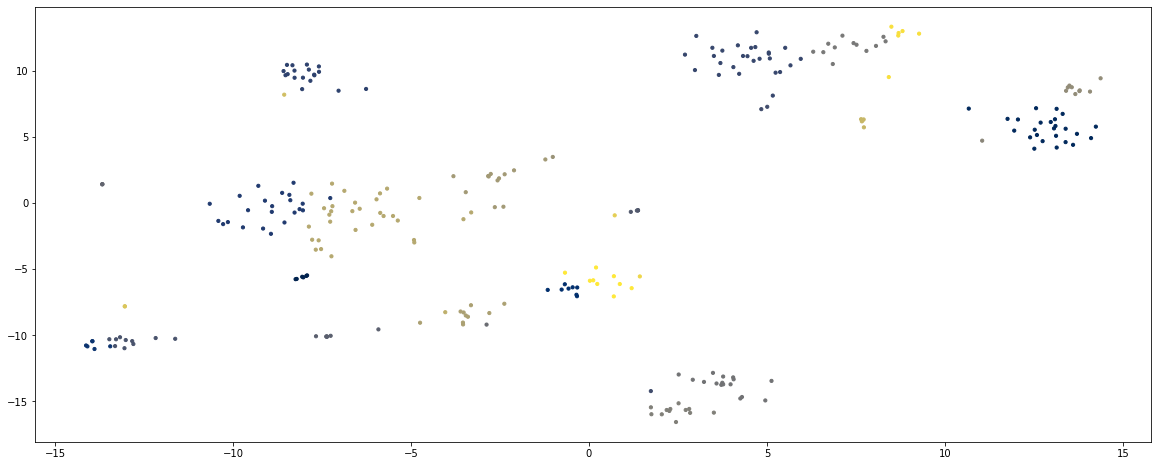

In [252]:
plt.figure(figsize=(20, 8))
plt.scatter(x=df_clustered['dim1'],y=df_clustered['dim2'], s=10, c=df_clustered['cluster'], cmap='cividis', alpha=1)
#para mostrar el texto de cada punto, descomentar las dos lineas siguientes.

#for i in range(wid):
#    plt.annotate(df_clustered['word'][i], (df_clustered['dim1'][i], df_clustered['dim2'][i]))

plt.show()